In [1]:
import torch
from torch import nn,optim
from mltools import ld,draw

In [2]:
train_iter,val_iter,test_iter=ld.mnist('./data',batch_size=1000) # 获取训练集、验证集和测试集
# 设置模型结构
model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),nn.ReLU(),
    nn.Linear(256,10))
device=torch.device('cuda') # 设置设备

Epoch 1, Training loss 0.9227887988090515, Validation loss 0.900580644607544
Epoch 2, Training loss 0.5551877617835999, Validation loss 0.565501868724823
Epoch 3, Training loss 0.5056231617927551, Validation loss 0.4547746181488037
Epoch 4, Training loss 0.3697614073753357, Validation loss 0.37922734022140503
Epoch 5, Training loss 0.4072718918323517, Validation loss 0.34490999579429626
Epoch 6, Training loss 0.3345465064048767, Validation loss 0.3695603311061859
Epoch 7, Training loss 0.3264486491680145, Validation loss 0.3058968186378479
Epoch 8, Training loss 0.31252628564834595, Validation loss 0.30867999792099
Epoch 9, Training loss 0.33069151639938354, Validation loss 0.30619463324546814
Epoch 10, Training loss 0.27680689096450806, Validation loss 0.29881778359413147
Epoch 11, Training loss 0.3115599751472473, Validation loss 0.27522915601730347
Epoch 12, Training loss 0.2534022331237793, Validation loss 0.3153563141822815
Epoch 13, Training loss 0.2593594789505005, Validation lo

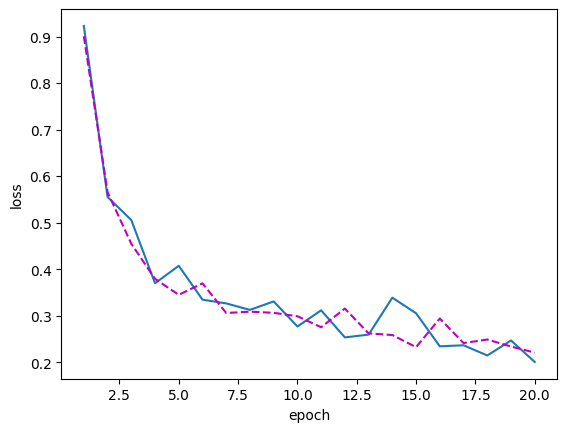

In [3]:
# 训练模型
def train(model,train_iter,val_iter,*,num_epochs,learing_rate,device):
    model.to(device) # 将网络复制到device上
    loss=nn.CrossEntropyLoss() # 定义损失函数
    optimizer=optim.SGD(model.parameters(),learing_rate) # 定义优化器
    train_losses,val_losses=[],[] # 记录训练集和验证集的损失值
    for epoch in range(1,num_epochs+1):
        # 计算训练集
        for x,y in train_iter:
            # 运算
            x,y=x.to(device),y.to(device)
            y_train=model(x)
            train_loss=loss(y_train,y)
            # 梯度更新
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        # 计算验证集
        with torch.no_grad():
            for x,y in val_iter:
                # 运算
                x,y=x.to(device),y.to(device)
                y_val=model(x)
                val_loss=loss(y_val,y)
        # 添加损失值
        train_losses.append(train_loss.detach().cpu())
        val_losses.append(val_loss.detach().cpu())
        print(f"Epoch {epoch}, Training loss {train_loss}, Validation loss {val_loss}") # 打印损失值
    draw.plot(y=[train_losses,val_losses],xlabel='epoch',ylabel='loss') # 画出损失图
train(model,train_iter,val_iter,num_epochs=20,learing_rate=1e-1,device=device)

In [4]:
# 测试模型
def test(model,test_iter,device):
    model.to(device) # 将网络复制到device上
    test_num,real_num=0,0 # 定义测试数量和预测真实数量
    # 测试
    for x,y in test_iter:
        x,y=x.to(device),y.to(device)
        y_test=model(x).argmax(dim=1)
        pred=y==y_test
        test_num+=len(pred)
        real_num+=pred.sum()
    print(f'Accuracy rate {real_num/test_num}') # 计算测试准确率并输出
test(model,test_iter,device)

Accuracy rate 0.949999988079071


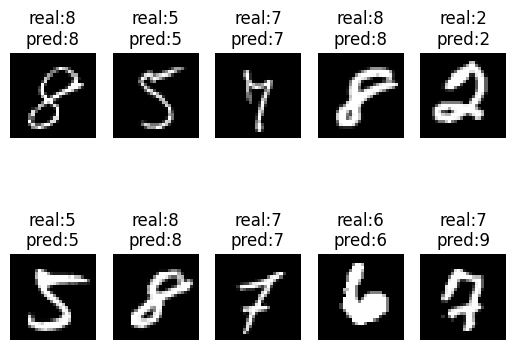

In [5]:
# 预测模型
def predict(model,test_iter,device):
    model.to(device) # 将网络复制到device上
    # 从测试中取一个批量
    x,y=next(iter(test_iter))
    x,y=x[:10].to(device),y[:10].to(device)
    # 预测
    y_pred=model(x).argmax(dim=1)
    labels=[f'real:{y[index]}\npred:{y_pred[index]}' for index in range(len(y))]
    # 输出样例图
    draw.images(x,labels,shape=(2,5))
predict(model,test_iter,device)